In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from featurizations import featurizations
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost", message="num_boost_rounds may not be used")

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500 # Resolution of figures
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.loc"] = 'best'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [3]:
fp_type = 'ecfp4'
cofactor_configuration = 'add_concat'
max_species = 4
model_type = 'XGBoost'

input_model_filepath = f'../../models/consolidated_models/all_BKM_rxns_{fp_type}_{model_type}_{max_species}_{cofactor_configuration}.pkl'
optimum_threshold_filepath = f'../../models/thresholds/all_BKM_rxns_{fp_type}_{model_type}_{max_species}_{cofactor_configuration}_feasibility_threshold.txt'

# load in selected model and its optimum threshold
model = pickle.load(open(input_model_filepath, 'rb'))
optimum_threshold = float(np.loadtxt(optimum_threshold_filepath))

In [4]:
all_cofactors_wo_stereo_filepath = '../../data/processed/expanded_cofactors_no_stereochem.tsv'
cofactors_df = pd.read_csv(all_cofactors_wo_stereo_filepath, delimiter=',')
all_cofactors_wo_stereo = set(cofactors_df['SMILES'])

In [5]:
known_pos_rxns_filepath = 'ecoli_metabolomics_untargeted_pos_rxns.pkl'
predicted_pos_rxns_filepath = 'untargeted_pos_reactions.csv'

neg_rxns_generated_from_known_pos_rxns_filepath = 'ecoli_metabolomics_untargeted_neg_rxns.pkl'
neg_rxns_generated_from_predicted_pos_rxns_filepath = 'nontargeted_neg.csv'

In [6]:
### Loading in experimentally validated new positive reactions and corresponding negative reactions

with open(known_pos_rxns_filepath, 'rb') as file:
    known_pos_rxns = pickle.load(file)
    
with open(neg_rxns_generated_from_known_pos_rxns_filepath,'rb') as file:
    neg_rxns_gen_frm_known_pos_rxns = pickle.load(file)
    
neg_rxns_gen_frm_known_pos_rxns = set(neg_rxns_gen_frm_known_pos_rxns)

### Loading in predicted positive reactions and corresponding negative reactions
predicted_pos_rxns = set(pd.read_csv(predicted_pos_rxns_filepath)['Reaction'])
neg_rxns_gen_frm_predicted_pos_rxns = set(pd.read_csv(neg_rxns_generated_from_predicted_pos_rxns_filepath)['Reaction'])

In [7]:
print(f'\nNumber of unique experimentally validated novel positive reactions: {len(known_pos_rxns)}')
print(f'\nNumber of unique predicted positive reactions: {len(predicted_pos_rxns )}')
print(f'\nNumber of unique negative reactions predicted from validated positive reactions: {len(neg_rxns_gen_frm_known_pos_rxns)}')
print(f'\nNumber of unique negative reactions predicted from predicted positive reactions: {len(neg_rxns_gen_frm_predicted_pos_rxns)}')


Number of unique experimentally validated novel positive reactions: 30

Number of unique predicted positive reactions: 40

Number of unique negative reactions predicted from validated positive reactions: 4536

Number of unique negative reactions predicted from predicted positive reactions: 17353


#### Calculating predicted feasibility labels of known, experimentally validated novel ecoli reactions

In [8]:
predicted_labels_of_known_pos_rxns = []
true_labels_of_known_pos_rxns = []

for rxn in known_pos_rxns:
    rxn_str = rxn['Reaction eq']
    
    rxn_obj = featurizations.reaction(rxn_str)
    
    fp = rxn_obj.rxn_2_fp_w_positioning(fp_type = 'ecfp4', 
                                        cofactor_positioning = cofactor_configuration,
                                        all_cofactors_wo_stereo = all_cofactors_wo_stereo)
    
    fp = fp.reshape(1, -1)
    feasib_score = model.predict_proba(fp)[:,1][0]

    if feasib_score >= optimum_threshold:
        feasib_label = 1
    else:
        feasib_label = 0
        
    predicted_labels_of_known_pos_rxns.append(feasib_label)
    true_labels_of_known_pos_rxns.append(1)

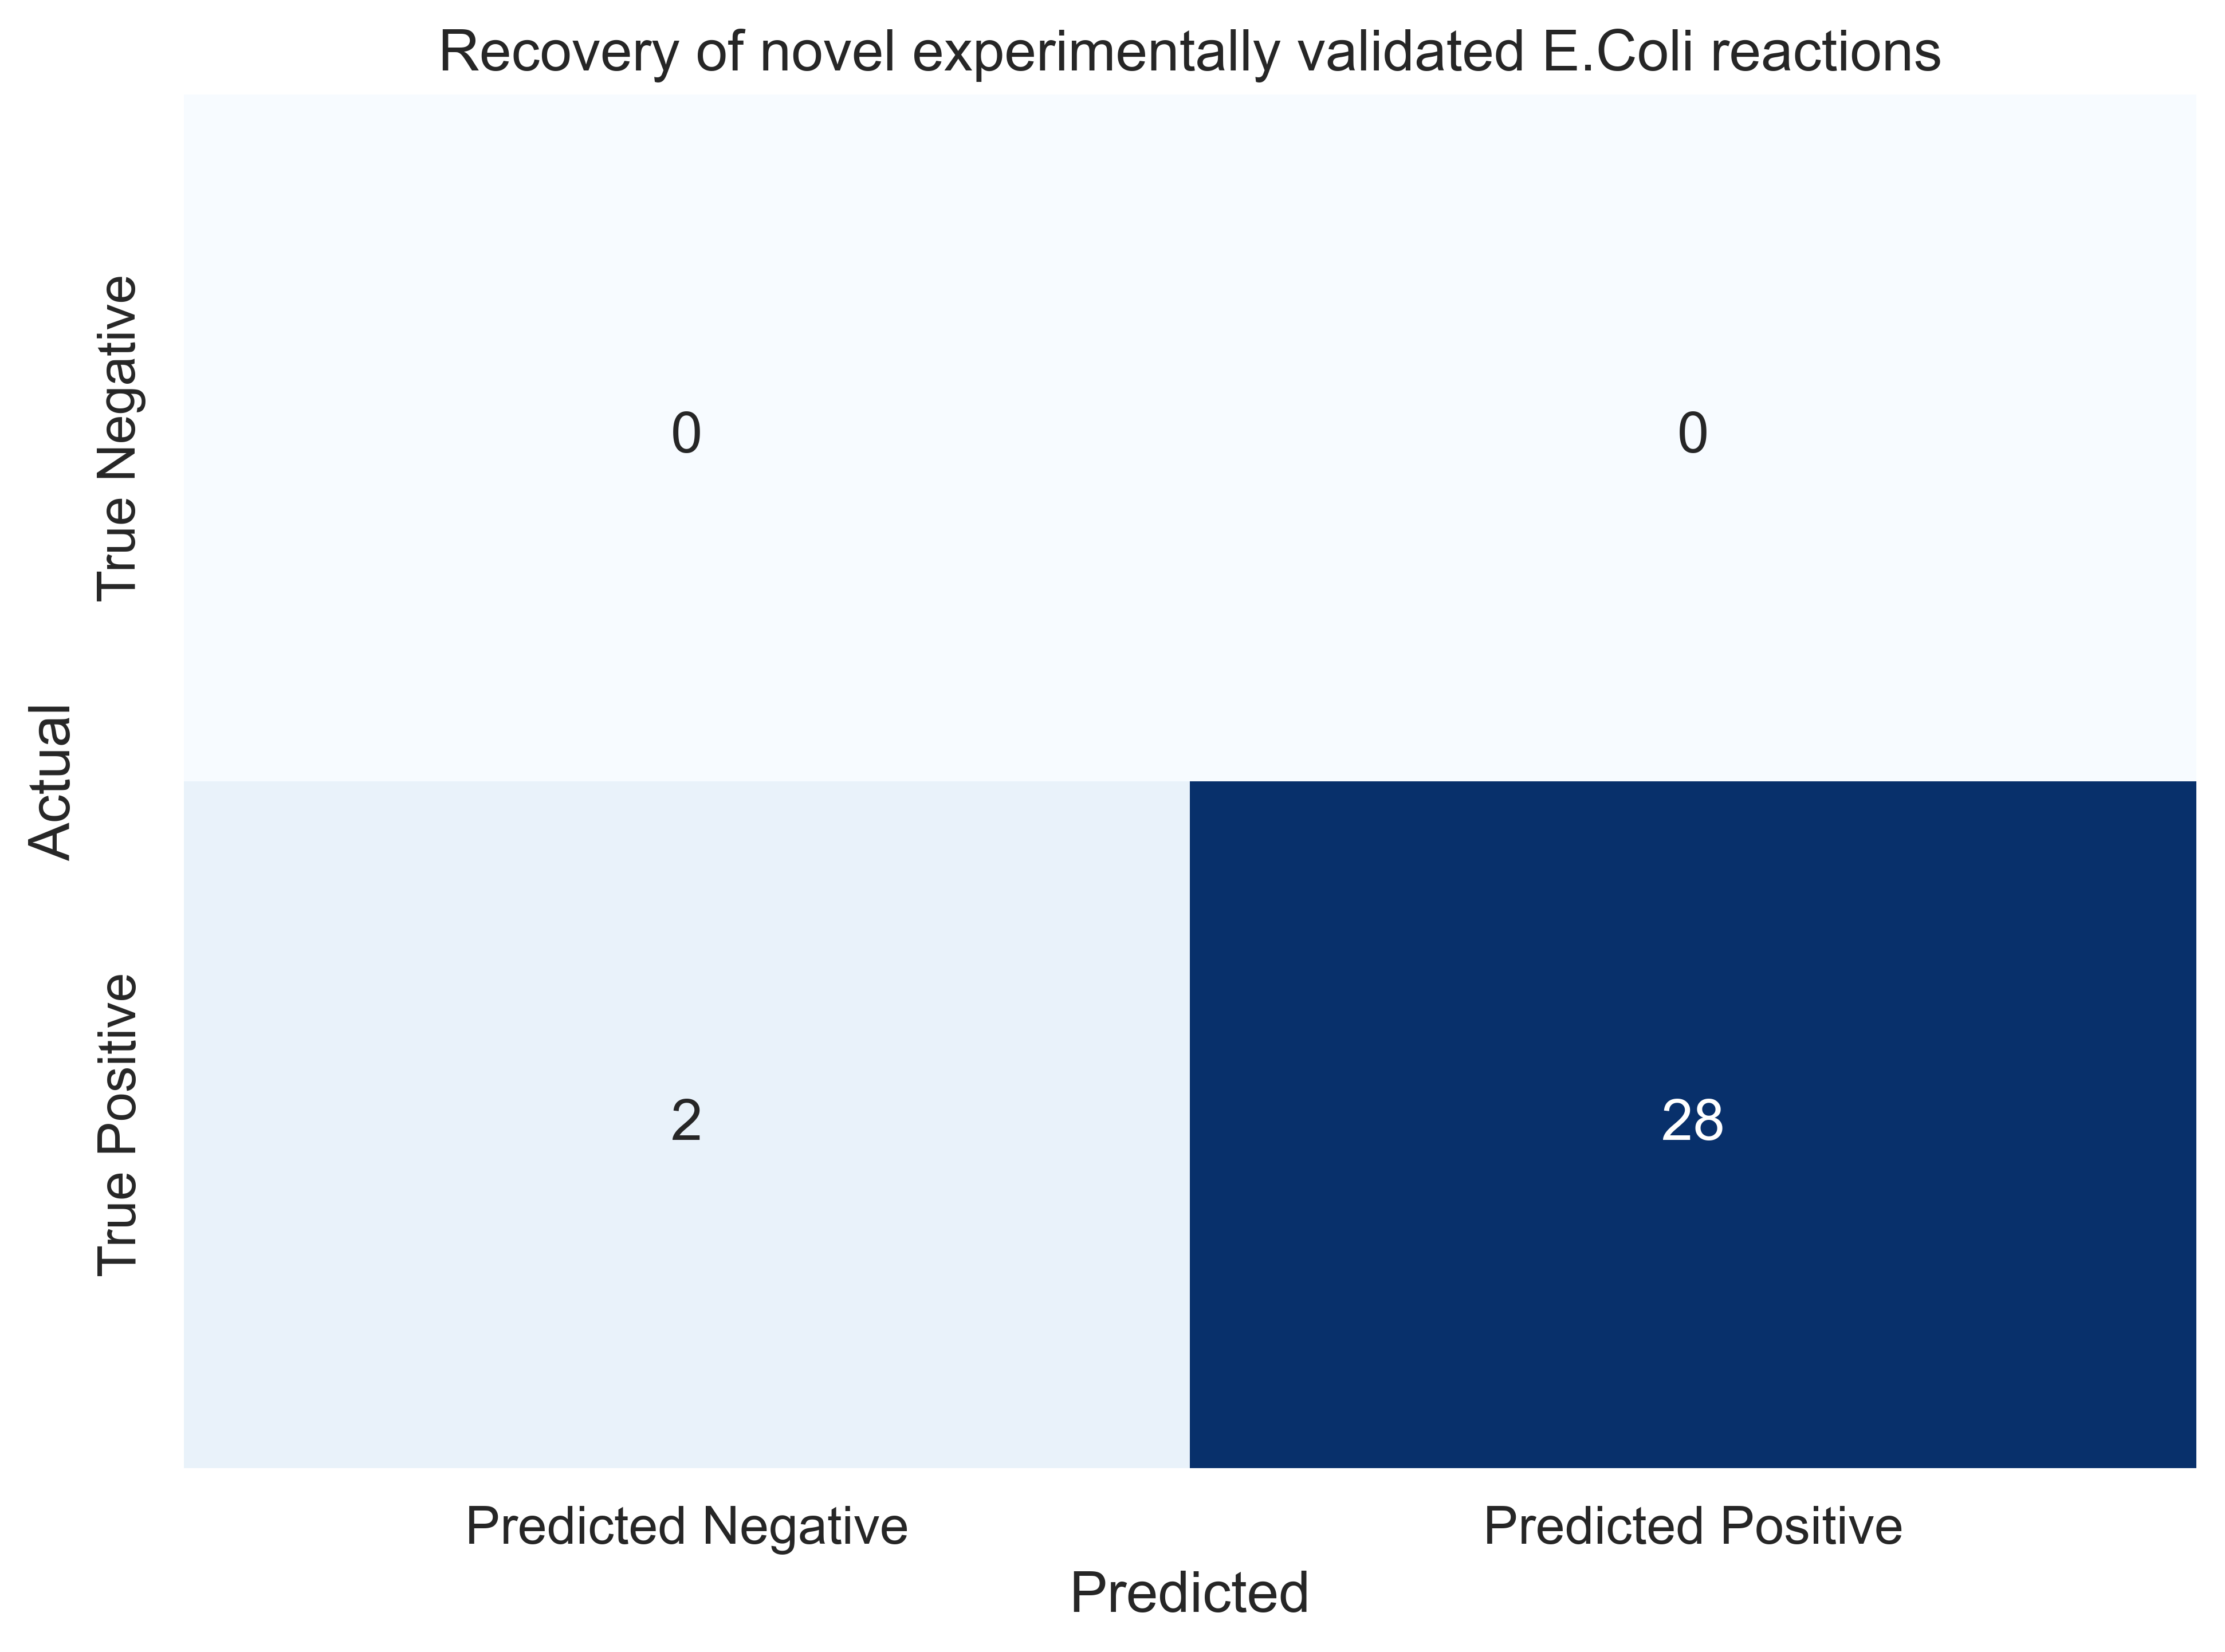

In [9]:
cm = confusion_matrix(true_labels_of_known_pos_rxns, predicted_labels_of_known_pos_rxns)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Recovery of novel experimentally validated E.Coli reactions')
plt.show()

#### Calculating predicted feasibility labels of predicted novel ecoli reactions

In [10]:
predicted_labels_of_predicted_pos_rxns = []
true_labels_of_predicted_pos_rxns = []

for rxn_str in predicted_pos_rxns:
    
    rxn_obj = featurizations.reaction(rxn_str)
    
    fp = rxn_obj.rxn_2_fp_w_positioning(fp_type = 'ecfp4', 
                                        cofactor_positioning = cofactor_configuration,
                                        all_cofactors_wo_stereo = all_cofactors_wo_stereo)
    
    fp = fp.reshape(1, -1)
    feasib_score = model.predict_proba(fp)[:,1][0]

    if feasib_score >= optimum_threshold:
        feasib_label = 1
    else:
        feasib_label = 0
        
    predicted_labels_of_predicted_pos_rxns.append(feasib_label)
    true_labels_of_predicted_pos_rxns.append(1)

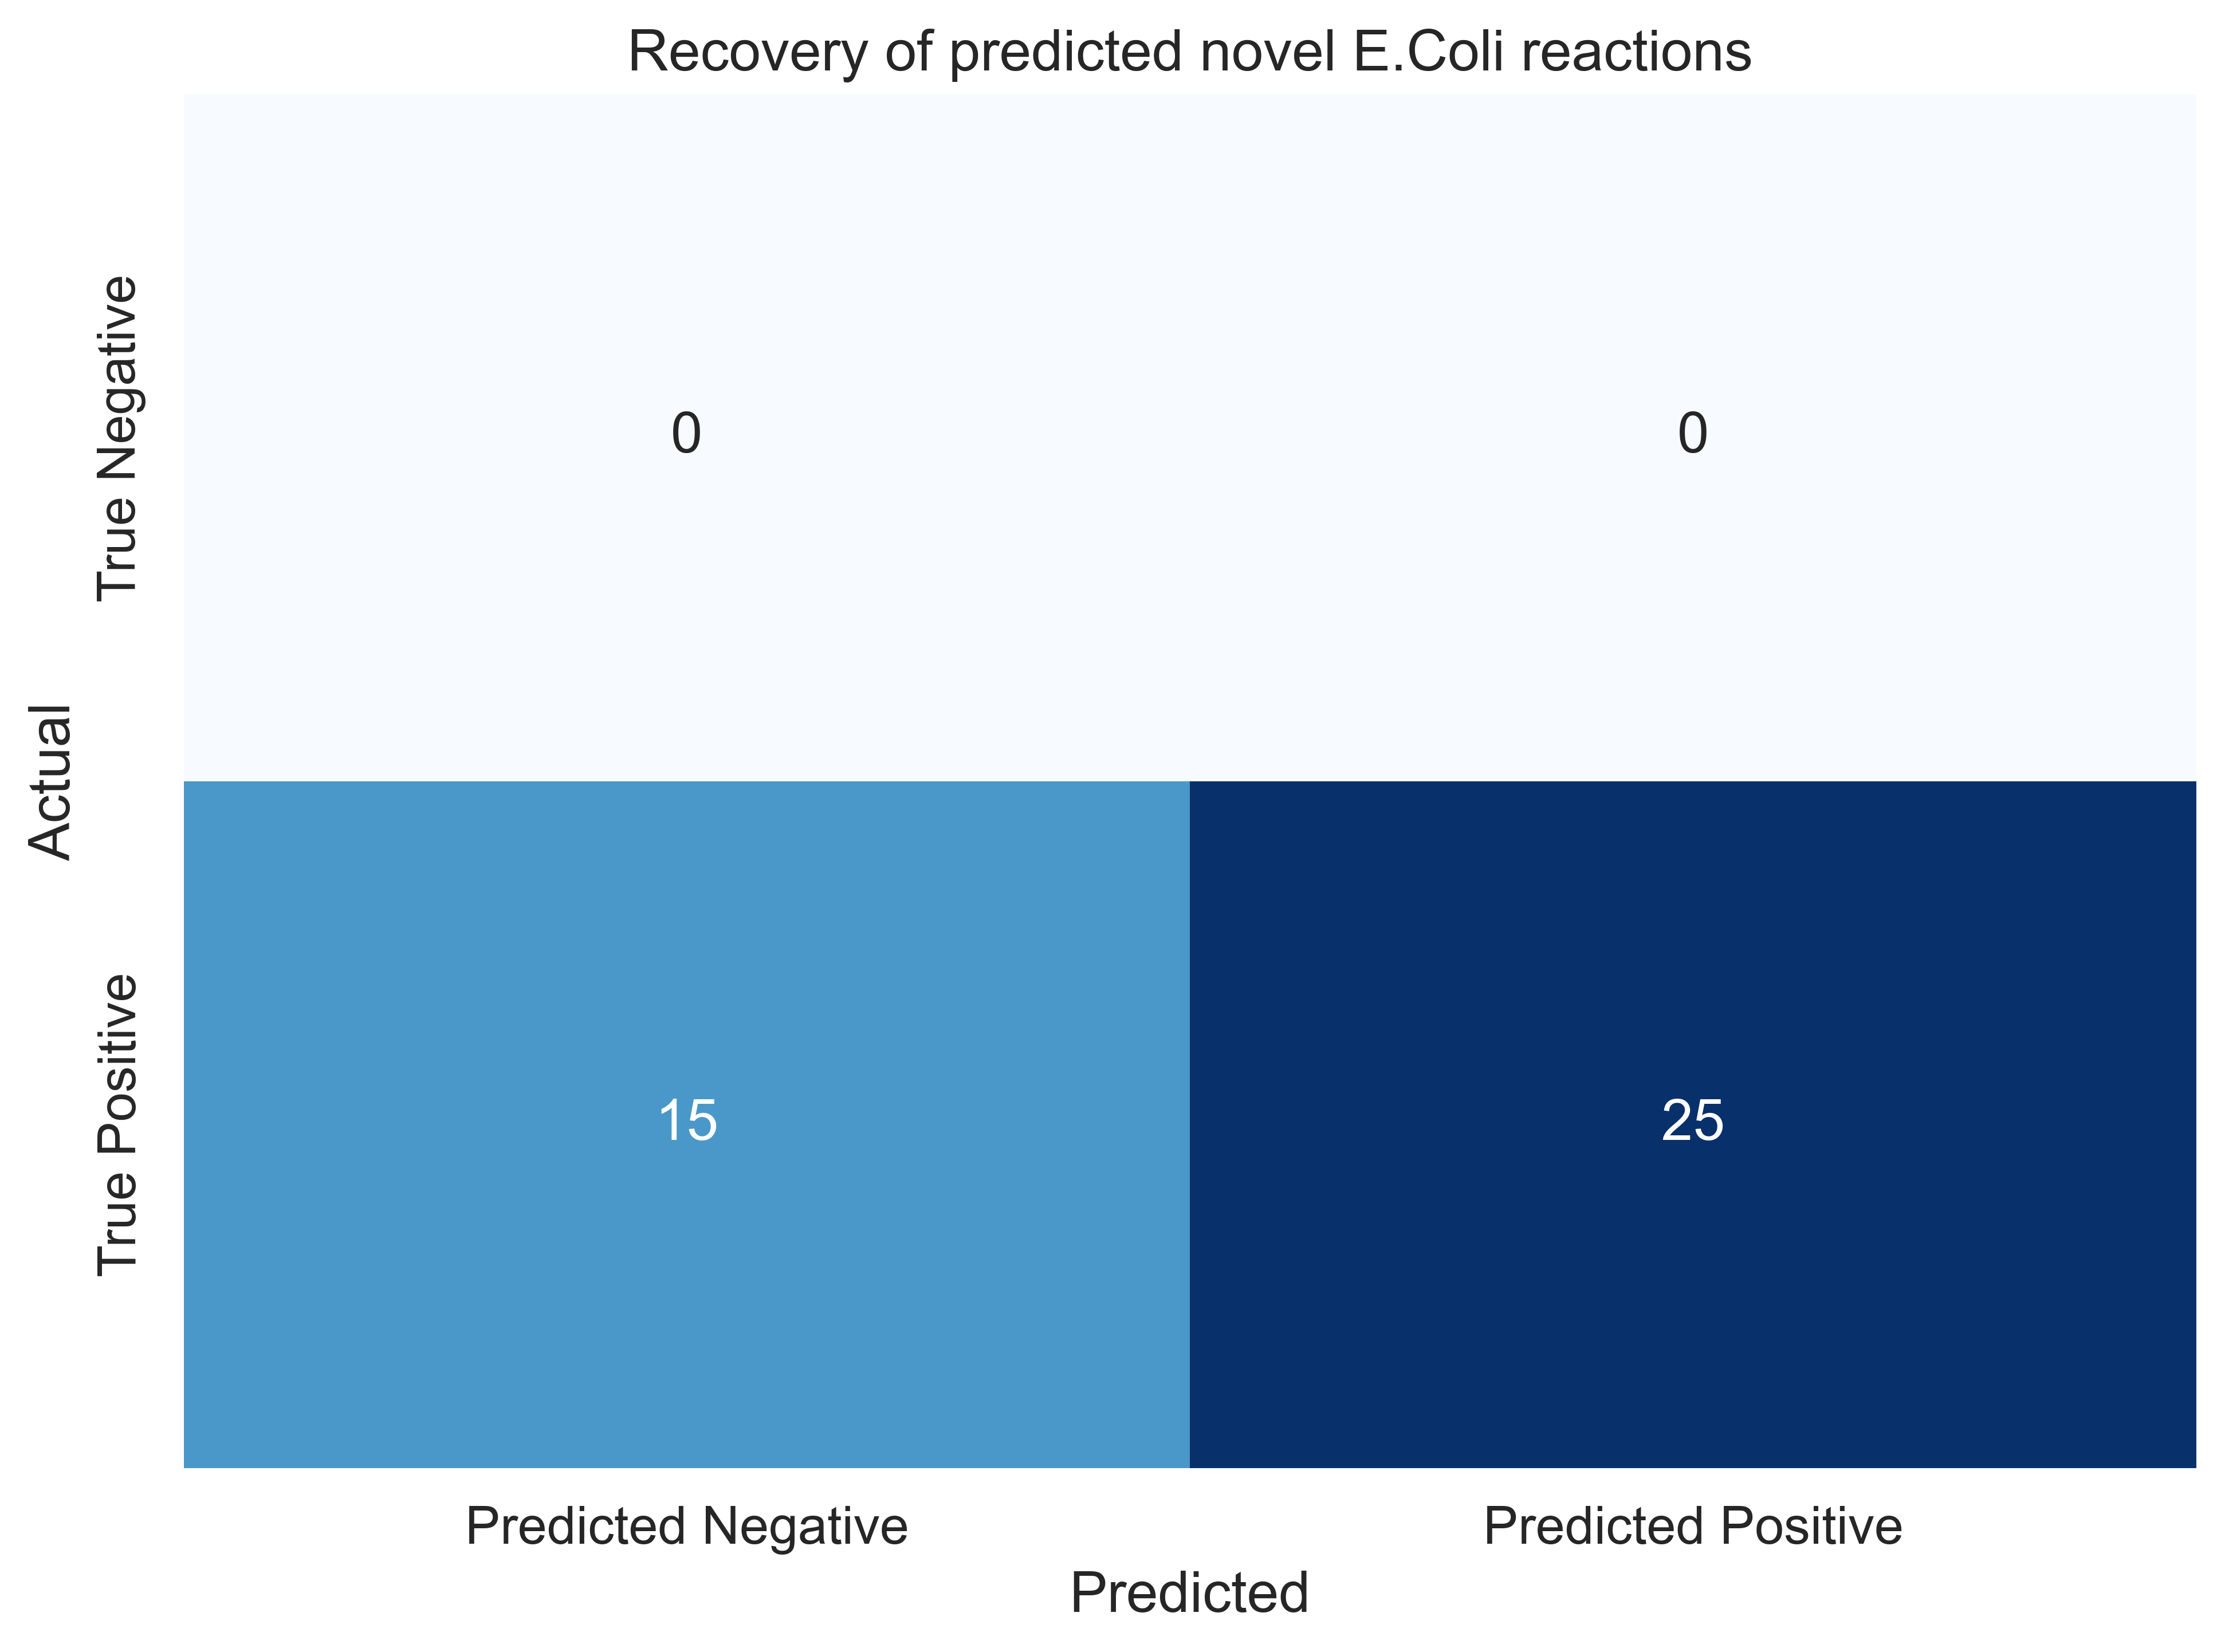

In [11]:
cm = confusion_matrix(true_labels_of_predicted_pos_rxns,predicted_labels_of_predicted_pos_rxns, )

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Recovery of predicted novel E.Coli reactions')
plt.show()

#### Calculating predicted feasibility labels of negative reactions predicted from known positive ecoli reactions

In [12]:
predicted_labels_of_predicted_neg_rxns = []
true_labels_of_predicted_neg_rxns = []

for rxn_str in neg_rxns_gen_frm_known_pos_rxns:
    
    rxn_obj = featurizations.reaction(rxn_str)
    
    fp = rxn_obj.rxn_2_fp_w_positioning(fp_type = 'ecfp4', 
                                        cofactor_positioning = cofactor_configuration,
                                        all_cofactors_wo_stereo = all_cofactors_wo_stereo)
    
    fp = fp.reshape(1, -1)
    feasib_score = model.predict_proba(fp)[:,1][0]

    if feasib_score >= optimum_threshold:
        feasib_label = 1
    else:
        feasib_label = 0
        
    predicted_labels_of_predicted_neg_rxns.append(feasib_label)
    true_labels_of_predicted_neg_rxns.append(0)

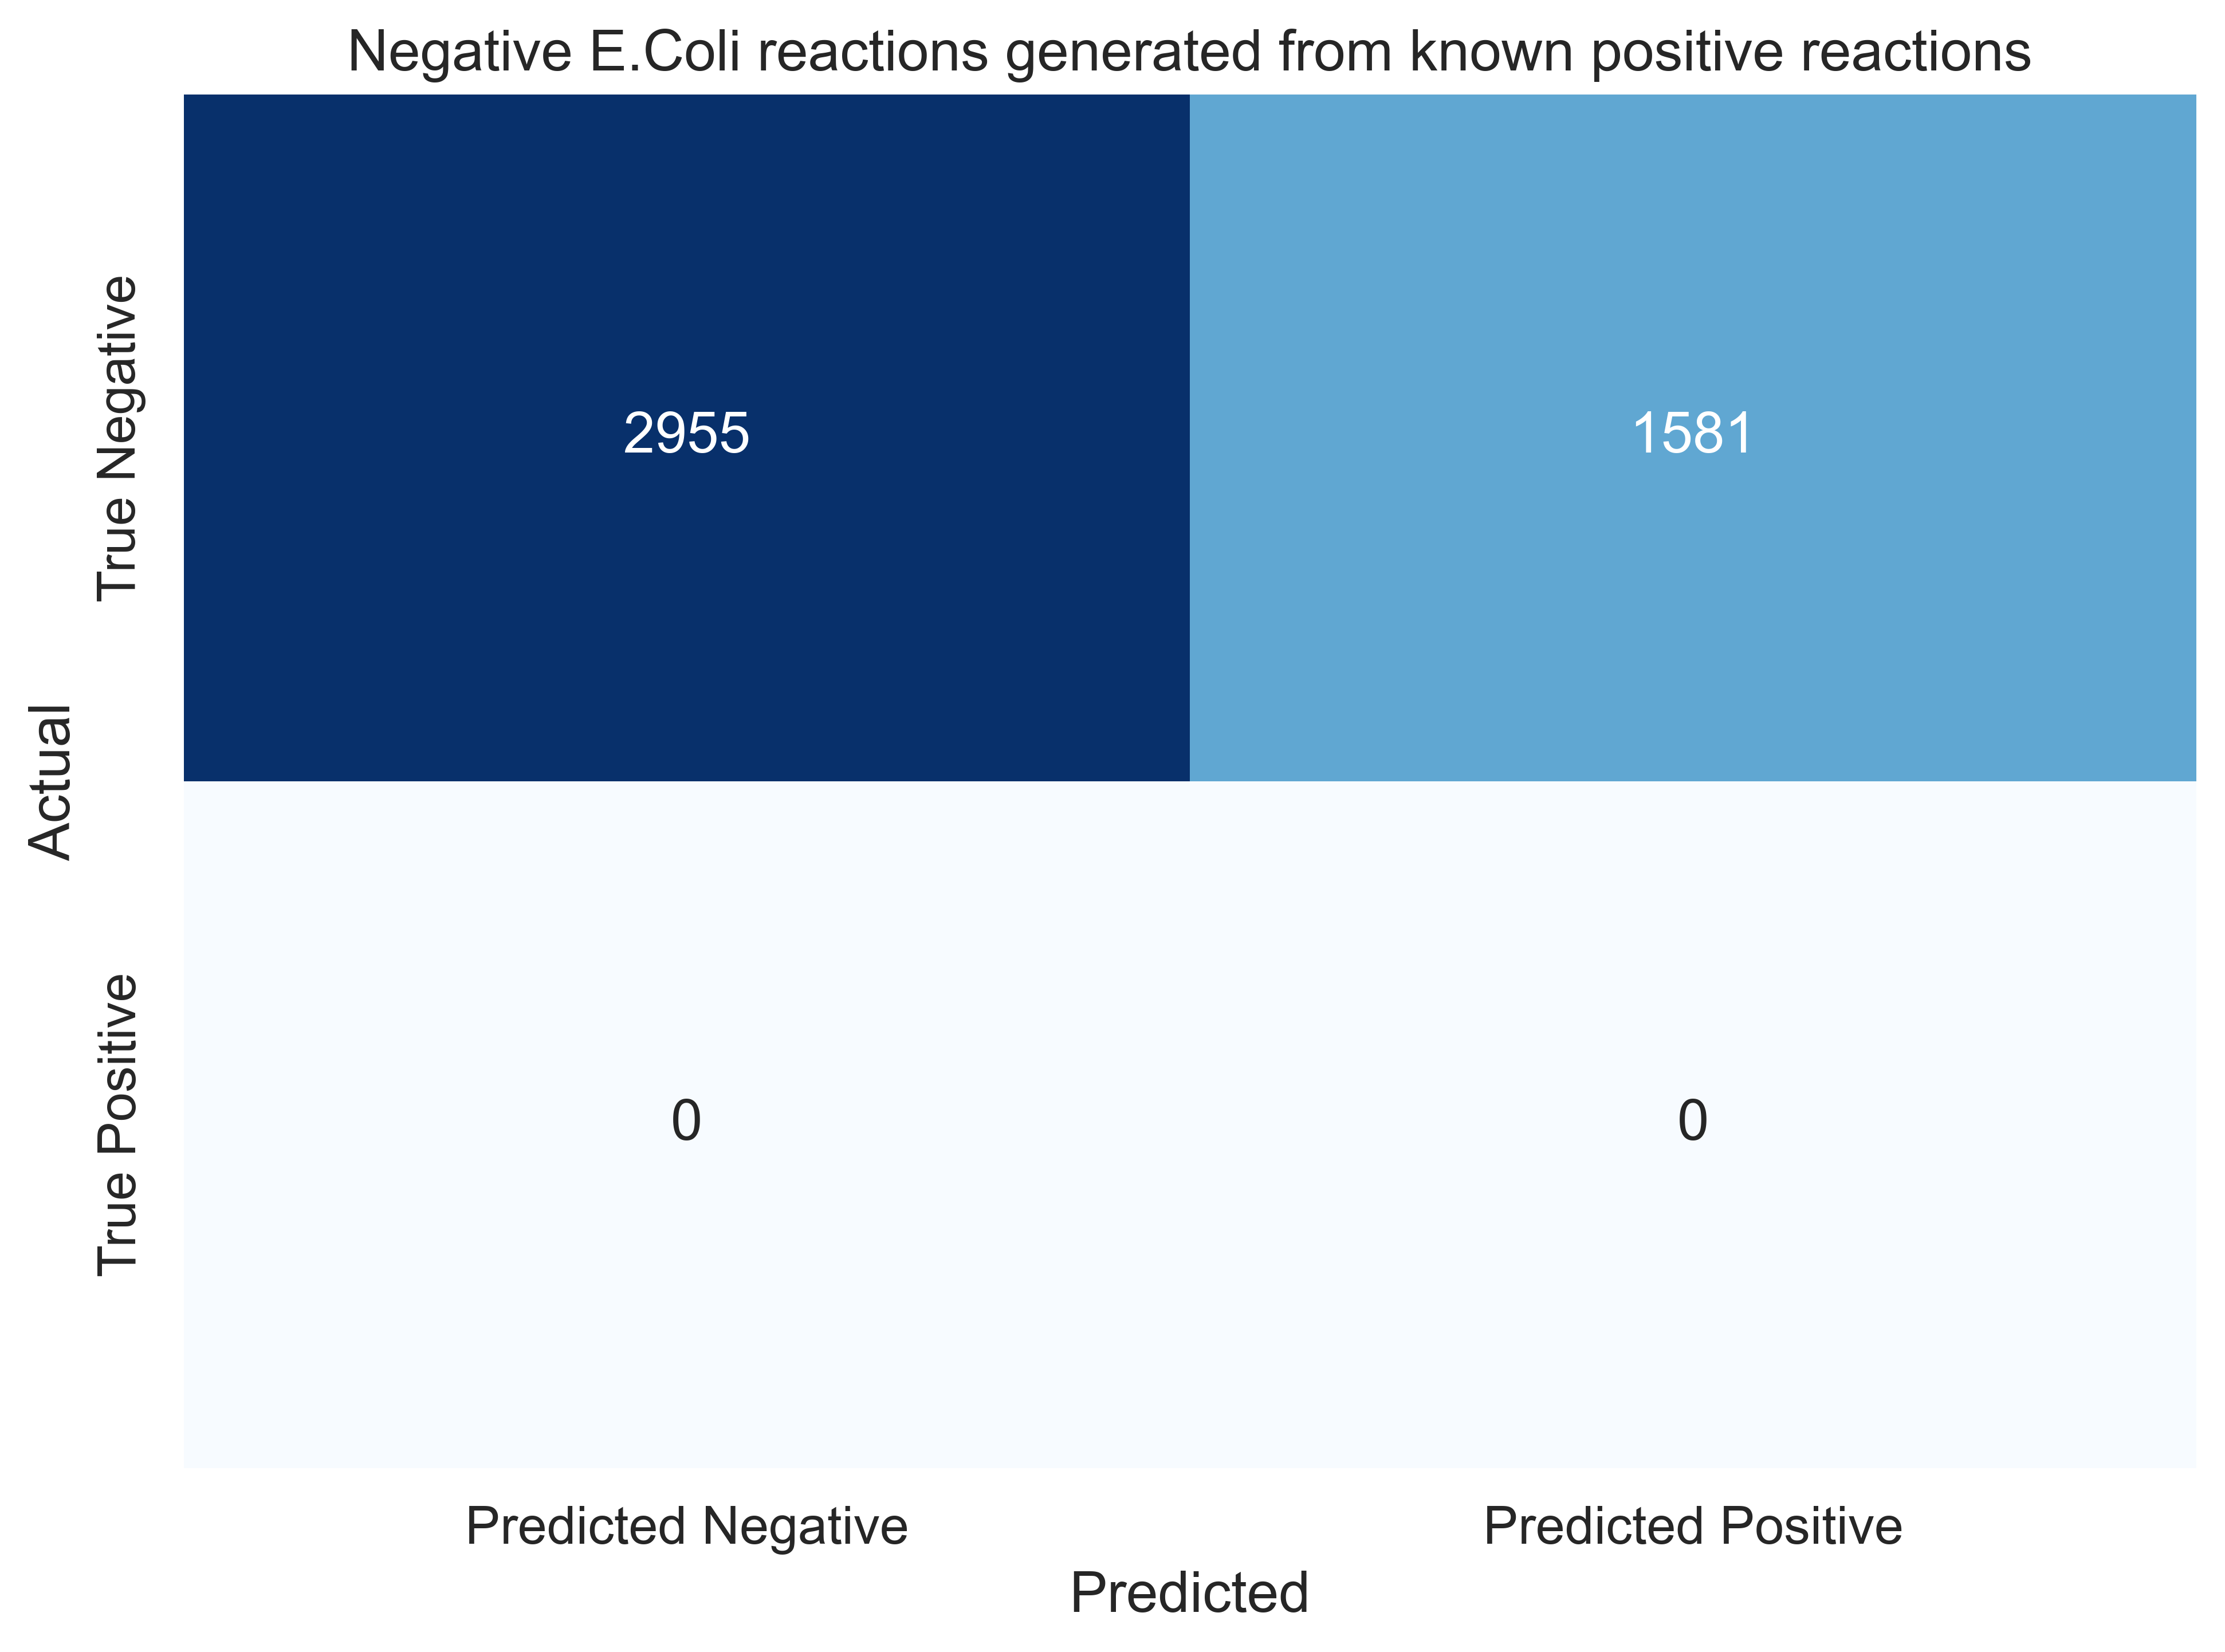

In [13]:
cm = confusion_matrix(true_labels_of_predicted_neg_rxns, predicted_labels_of_predicted_neg_rxns)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Negative E.Coli reactions generated from known positive reactions')
plt.show()

#### Calculating predicted feasibility labels of negative reactions predicted from predicted positive ecoli reactions

In [14]:
predicted_labels_of_predicted_neg_rxns = []
true_labels_of_predicted_neg_rxns = []

for rxn_str in neg_rxns_gen_frm_predicted_pos_rxns:
    
    rxn_obj = featurizations.reaction(rxn_str)
    
    fp = rxn_obj.rxn_2_fp_w_positioning(fp_type = 'ecfp4', 
                                        cofactor_positioning = cofactor_configuration,
                                        all_cofactors_wo_stereo = all_cofactors_wo_stereo)
    
    fp = fp.reshape(1, -1)
    feasib_score = model.predict_proba(fp)[:,1][0]

    if feasib_score >= optimum_threshold:
        feasib_label = 1
    else:
        feasib_label = 0
        
    predicted_labels_of_predicted_neg_rxns.append(feasib_label)
    true_labels_of_predicted_neg_rxns.append(0)

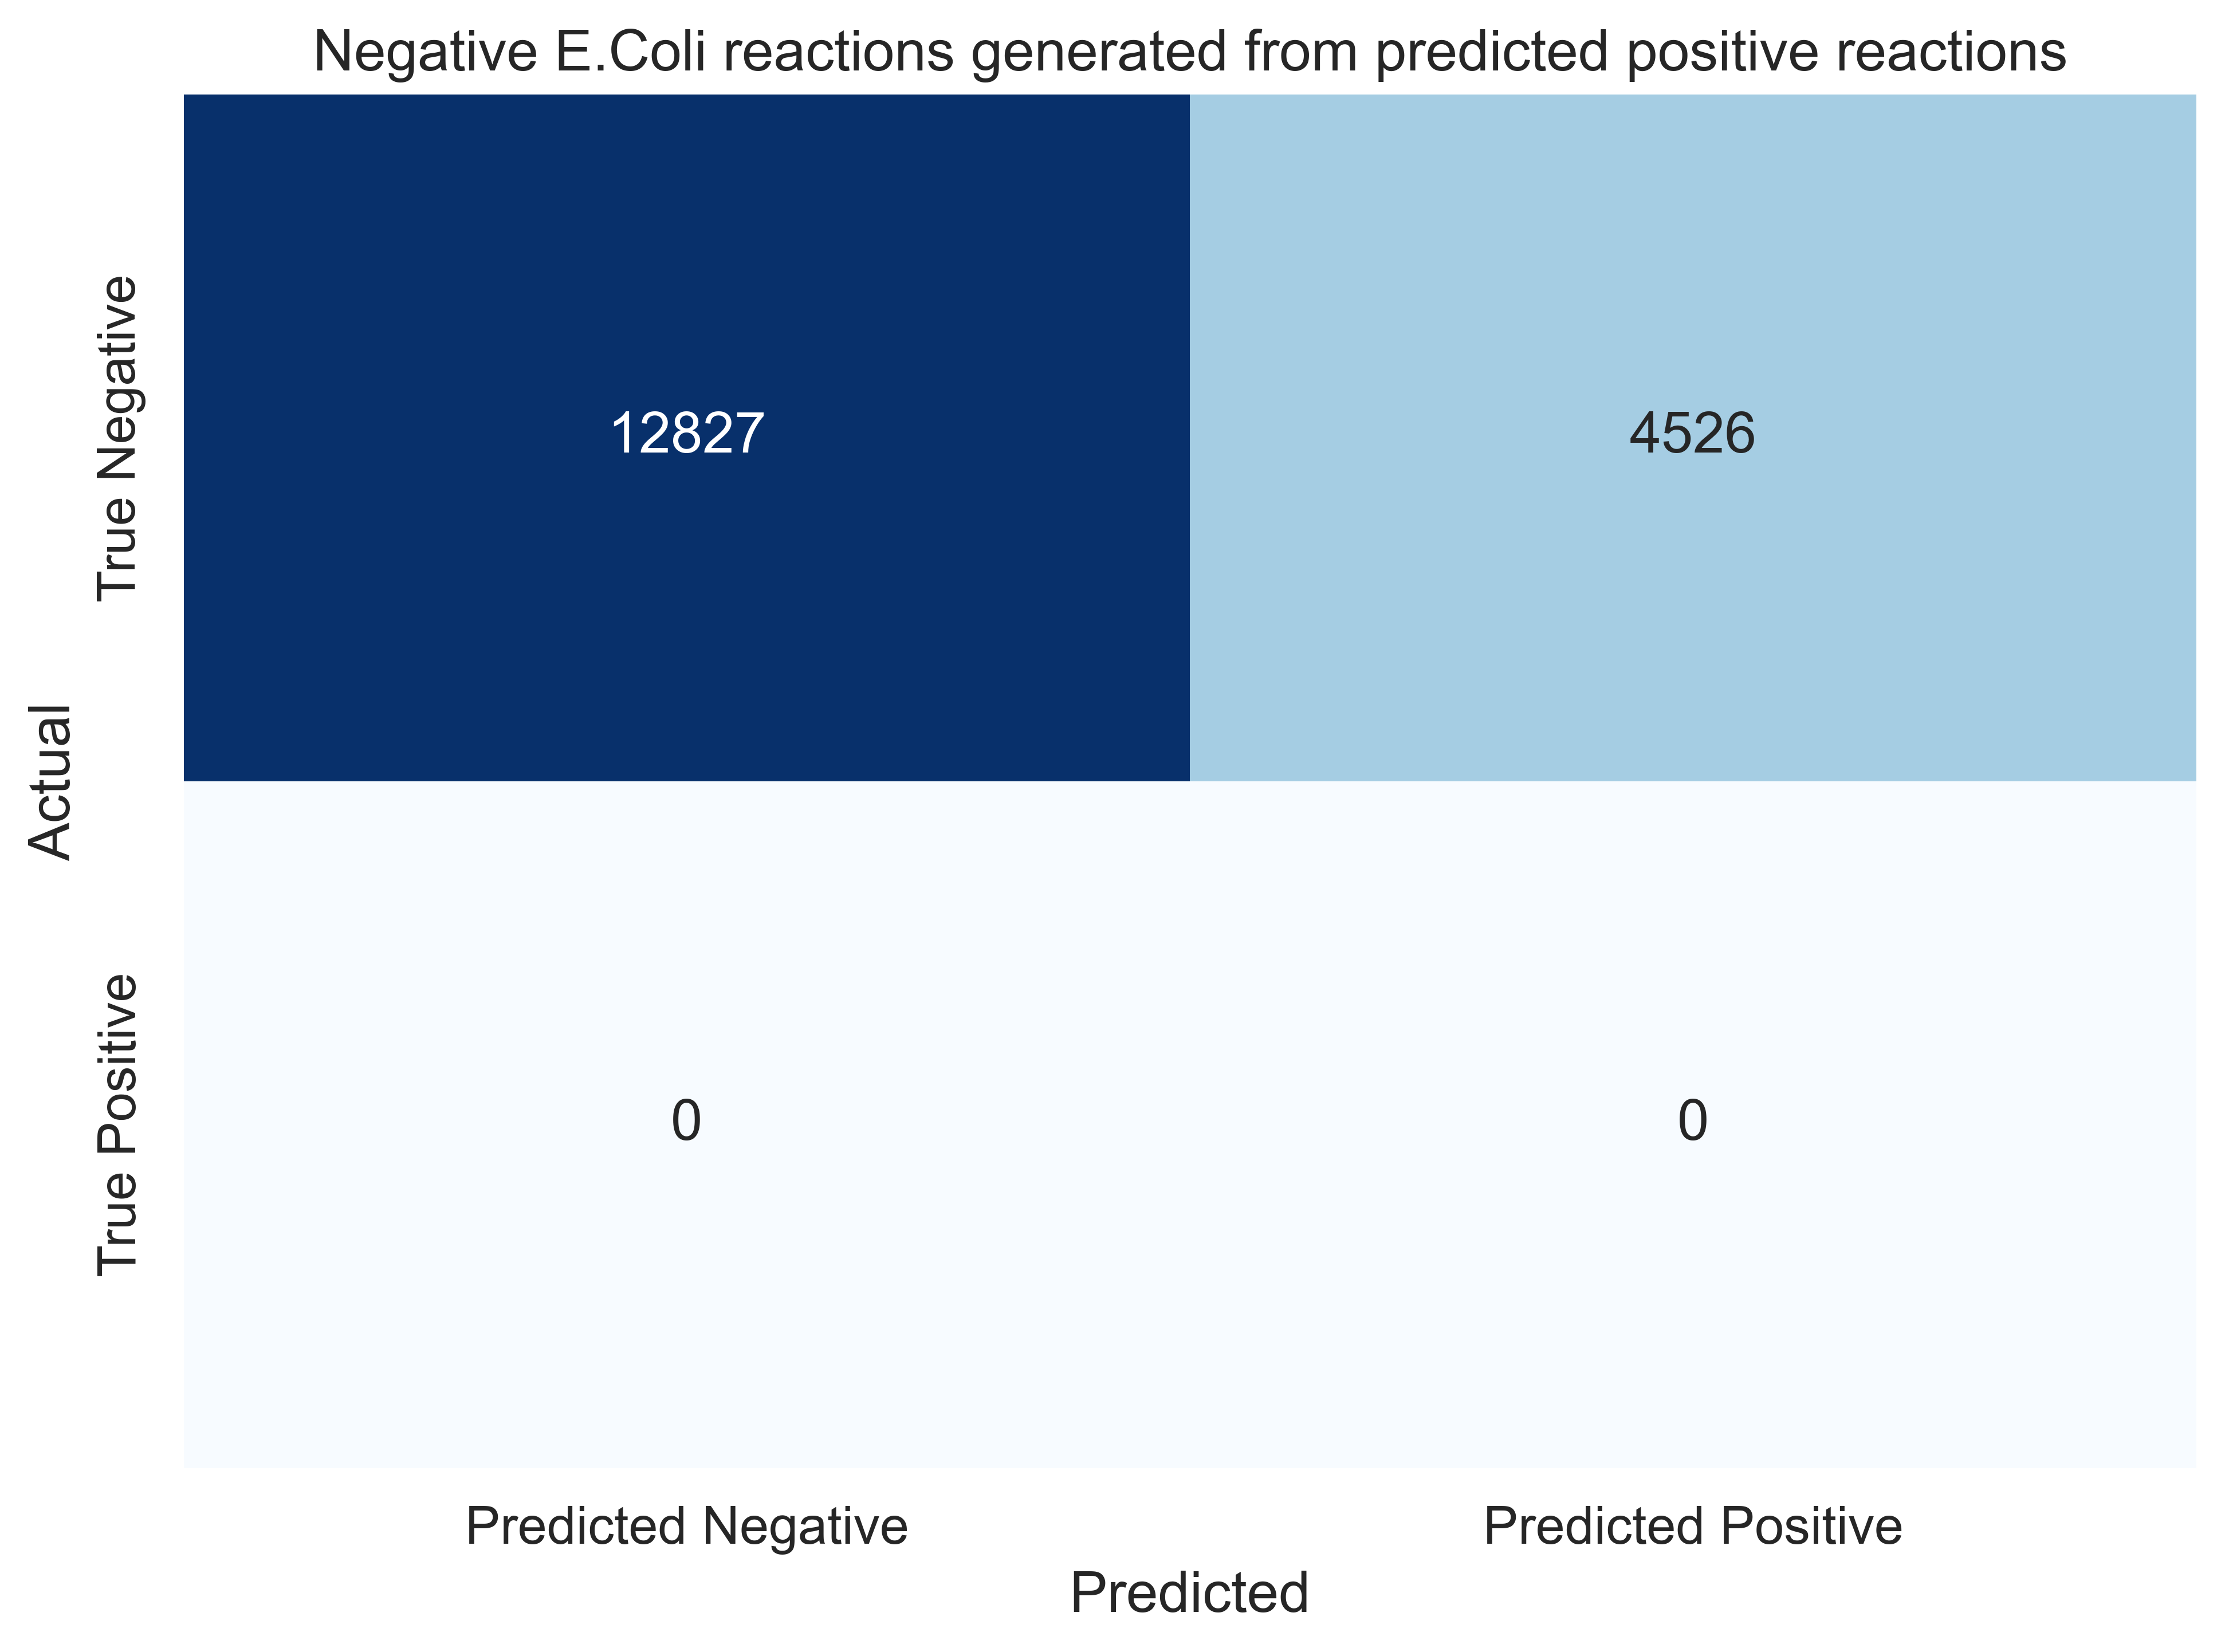

In [16]:
cm = confusion_matrix(true_labels_of_predicted_neg_rxns, predicted_labels_of_predicted_neg_rxns)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Negative E.Coli reactions generated from predicted positive reactions')
plt.show()